In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

import nengo_loihi
import nengo
from nengo.processes import WhiteSignal
from nengo.dists import Distribution, UniformHypersphere
from scipy.special import beta, betainc, betaincinv
from scipy.linalg import svd


n_scale = 100
np.random.seed(42)
os.environ["SLURM"] = "1"

class Rd(Distribution):

    def __repr__(self):
        return "%s()" % (type(self).__name__)

    def sample(self, n, d=1, rng=np.random):
        """Samples ``n`` points in ``d`` dimensions."""
        if d == 1:
            # Tile the points optimally. 
            return np.linspace(1.0 / n, 1, n)[:, None]
        if d is None or not isinstance(d, (int, np.integer)) or d < 1:
            raise ValueError("d (%d) must be positive integer" % d)
        return _rd_generate(n, d)

class ScatteredHypersphere(UniformHypersphere):

    def __init__(self, surface, base=Rd()):
        super(ScatteredHypersphere, self).__init__(surface)
        self.base = base

    def __repr__(self):
        return "%s(surface=%r, base=%r)" % (
            type(self).__name__,
            self.surface,
            self.base,
        )

    def sample(self, n, d=1, rng=np.random):
        """Samples ``n`` points in ``d`` dimensions."""
        if d == 1:
            return super(ScatteredHypersphere, self).sample(n, d, rng)

        if self.surface:
            samples = self.base.sample(n, d - 1, rng)
            radius = 1.0
        else:
            samples = self.base.sample(n, d, rng)
            samples, radius = samples[:, :-1], samples[:, -1:] ** (1.0 / d)

        mapped = spherical_transform(samples)

        # radius adjustment for ball versus sphere, and a random rotation
        rotation = random_orthogonal(d, rng=rng)
        return np.dot(mapped * radius, rotation)


class SphericalCoords(Distribution):

    def __init__(self, m):
        super(SphericalCoords, self).__init__()
        self.m = m

    def __repr__(self):
        return "%s(%r)" % (type(self).__name__, self.m)

    def sample(self, n, d=None, rng=np.random):
        """Samples ``n`` points in ``d`` dimensions."""
        shape = self._sample_shape(n, d)
        y = rng.uniform(size=shape)
        return self.ppf(y)

    def pdf(self, x):
        """Evaluates the PDF along the values ``x``."""
        return np.pi * np.sin(np.pi * x) ** (self.m - 1) / beta(self.m / 2.0, 0.5)

    def cdf(self, x):
        """Evaluates the CDF along the values ``x``."""
        y = 0.5 * betainc(self.m / 2.0, 0.5, np.sin(np.pi * x) ** 2)
        return np.where(x < 0.5, y, 1 - y)

    def ppf(self, y):
        """Evaluates the inverse CDF along the values ``x``."""
        y_reflect = np.where(y < 0.5, y, 1 - y)
        z_sq = betaincinv(self.m / 2.0, 0.5, 2 * y_reflect)
        x = np.arcsin(np.sqrt(z_sq)) / np.pi
        return np.where(y < 0.5, x, 1 - x)


def random_orthogonal(d, rng=None):

    rng = np.random if rng is None else rng
    m = UniformHypersphere(surface=True).sample(d, d, rng=rng)
    u, s, v = svd(m)
    return np.dot(u, v)

def _rd_generate(n, d, seed=0.5):

    def gamma(d, n_iter=20):
        """Newton-Raphson-Method to calculate g = phi_d."""
        x = 1.0
        for _ in range(n_iter):
            x -= (x ** (d + 1) - x - 1) / ((d + 1) * x ** d - 1)
        return x

    g = gamma(d)
    alpha = np.zeros(d)
    for j in range(d):
        alpha[j] = (1 / g) ** (j + 1) % 1

    z = np.zeros((n, d))
    z[0] = (seed + alpha) % 1
    for i in range(1, n):
        z[i] = (z[i - 1] + alpha) % 1

    return z

def spherical_transform(samples):

    samples = np.asarray(samples)
    samples = samples[:, None] if samples.ndim == 1 else samples
    coords = np.empty_like(samples)
    n, d = coords.shape

    # inverse transform method (section 1.5.2)
    for j in range(d):
        coords[:, j] = SphericalCoords(d - j).ppf(samples[:, j])

    # spherical coordinate transform
    mapped = np.ones((n, d + 1))
    i = np.ones(d)
    i[-1] = 2.0
    s = np.sin(i[None, :] * np.pi * coords)
    c = np.cos(i[None, :] * np.pi * coords)
    mapped[:, 1:] = np.cumprod(s, axis=1)
    mapped[:, :-1] *= c
    return mapped

def get_encoders (n_neurons, dimensions):
    encoders_dist = ScatteredHypersphere(surface=True)
    
encoders_dist = ScatteredHypersphere(surface=True)

def get_intercepts(n_neurons, dimensions):

    triangular = np.random.triangular(left=0.35, 
                                      mode=0.45, 
                                      right=0.55, 
                                      size=n_neurons)
                                      
    intercepts = nengo.dists.CosineSimilarity(dimensions + 2).ppf(1 - triangular)
    return intercepts

def calc_T(q):

    c0 = np.cos(q[0])
    c1 = np.cos(q[1])
    c2 = np.cos(q[2])
    c3 = np.cos(q[3])
    c4 = np.cos(q[4])
    
    s0 = np.sin(q[0])
    s1 = np.sin(q[1])
    s2 = np.sin(q[2])
    s3 = np.sin(q[3])
    s4 = np.sin(q[4])
    
    return np.array([[0.208*((-s1*c0*c2 - s2*c0*c1)*c3 + s0*s3)*s4 + 
                      0.208*(-s1*s2*c0 + c0*c1*c2)*c4 - 0.299*s1*s2*c0 - 
                      0.3*s1*c0 + 0.299*c0*c1*c2 + 0.06*c0*c1],
                     [0.208*(-s1*s2 + c1*c2)*s4*c3 + 
                      0.208*(s1*c2 + s2*c1)*c4 + 
                      0.299*s1*c2 + 0.06*s1 + 0.299*s2*c1 + 0.3*c1 + 0.118],
                     [0.208*((s0*s1*c2 + s0*s2*c1)*c3 + s3*c0)*s4 + 
                      0.208*(s0*s1*s2 - s0*c1*c2)*c4 + 0.299*s0*s1*s2 + 
                      0.3*s0*s1 - 0.299*s0*c1*c2 - 0.06*s0*c1]], dtype='float')

def calc_J(q):

    c0 = np.cos(q[0])
    c1 = np.cos(q[1])
    c2 = np.cos(q[2])
    c3 = np.cos(q[3])
    c4 = np.cos(q[4])
    
    s0 = np.sin(q[0])
    s1 = np.sin(q[1])
    s2 = np.sin(q[2])
    s3 = np.sin(q[3])
    s4 = np.sin(q[4])

    s12  = np.sin(q[1] + q[2])
    c12  = np.cos(q[1] + q[2])

    
    return np.array([[0.3*s0*s1 + 0.208*s0*s4*s12*c3 - 0.06*s0*c1 - 0.208*s0*c4*c12 - 
                      0.299*s0*c12 + 0.208*s3*s4*c0, -(0.06*s1 + 0.208*s4*c3*c12 + 
                      0.208*s12*c4 + 0.299*s12 + 0.3*c1)*c0,
                      -(0.208*s4*c3*c12 + 0.208*s12*c4 + 0.299*s12)*c0,
                      0.208*(s0*c3 + s3*s12*c0)*s4, 0.208*(s0*s3 - s12*c0*c3)*c4 - 
                      0.208*s4*c0*c12],
                     [0,-0.3*s1 - 0.208*s4*s12*c3 + 0.06*c1 + 0.208*c4*c12 + 0.299*c12,
                      -0.208*s4*s12*c3 + 0.208*c4*c12 + 0.299*c12,-0.208*s3*s4*c12,
                      -0.208*s4*s12 + 0.208*c3*c4*c12],
                     [-0.208*s0*s3*s4 + 0.3*s1*c0 + 0.208*s4*s12*c0*c3 - 0.06*c0*c1 - 
                      0.208*c0*c4*c12 -0.299*c0*c12,(0.06*s1 + 0.208*s4*c3*c12 + 0.208*s12*c4 + 
                      0.299*s12 + 0.3*c1)*s0,(0.208*s4*c3*c12 + 0.208*s12*c4 + 
                      0.299*s12)*s0, -0.208*(s0*s3*s12 - c0*c3)*s4,
                      0.208*(s0*s12*c3 + s3*c0)*c4 + 0.208*s0*s4*c12]], dtype='float')

current_q   = [0.0, 0.0, 0.0, 0.0, 0.0] 
target_xyz = [0.667, 0.318, 0.2]

def inverse_kinematics(lr = 1e-3):
    model = nengo.Network()
    count = 0
    with model:
        
        model.q_in = nengo.Node(current_q)
        model.q_c = nengo.Ensemble(n_scale*5, seed=0,
                             intercepts=get_intercepts(n_scale*5, 5),
                             #encoders = encoders_dist.sample(n_scale*5, 5),
                             dimensions=5)
        nengo.Connection(model.q_in, model.q_c)

        model.q_t = nengo.Ensemble(n_scale*5, dimensions=5,seed=0,
                             intercepts=get_intercepts(n_scale*5, 5),
                             #encoders = encoders_dist.sample(n_scale*5, 5),
                            )
        model.conn = nengo.Connection(model.q_c, model.q_t, synapse=0.01)

        model.xyz_t = nengo.Ensemble(n_scale*3, dimensions=3,seed=0,
                               intercepts=get_intercepts(n_scale*3, 5),
                               #encoders = encoders_dist.sample(n_scale*3, 3),
                              )

        def q2xyz(q):
            t = calc_T(q)
            return t[0], t[1], t[2]

        nengo.Connection(model.q_t, model.xyz_t, function=q2xyz)

        model.xyz_in = nengo.Node(target_xyz)
        nengo.Connection(model.xyz_in, model.xyz_t, transform=-1)

        model.error_node = nengo.Node(size_in=8)
        model.error_q = nengo.Ensemble(n_scale*8, dimensions=8,seed=0,
                                intercepts=get_intercepts(n_scale*8, 8),
                                 #encoders = encoders_dist.sample(n_scale*8, 8)
                                )

        def combine(error_q):
            J_x = calc_J(error_q[0:5])
            return np.dot(np.linalg.pinv(J_x), error_q[5:])

        nengo.Connection(model.q_t, model.error_node[0:5])
        nengo.Connection(model.xyz_t, model.error_node[5:])

        nengo.Connection(model.error_node, model.error_q)

        model.error_combined = nengo.Ensemble(n_scale*5, dimensions=5,seed=0,
                                        intercepts=get_intercepts(n_scale*5, 5),
                                        #encoders = encoders_dist.sample(n_scale*5, 5),
                                       )
        nengo.Connection(model.error_q, model.error_combined, function=combine, synapse=0.01)

        model.conn.learning_rule_type = nengo.PES(learning_rate=lr)
        nengo.Connection(model.error_combined, model.conn.learning_rule)
        
        
        # Shut off learning by inhibiting the error population
        model.stop_learning = nengo.Node(output=lambda t: t >= 10)

        nengo.Connection(
            model.stop_learning, model.error_combined.neurons, 
            transform=-20 * np.ones((model.error_combined.n_neurons, 1))
        )
        

        def comp_error(error_combined):
            return np.sqrt(sum(np.power(error_combined, 2)))

        model.error_out = nengo.Node(size_in=1, size_out=1)
        nengo.Connection(model.error_combined, model.error_out, function=comp_error)

                
        
        
        model.q_c_probe = nengo.Probe(model.q_c, synapse=0.01)
        model.q_t_probe = nengo.Probe(model.q_t, synapse=0.1)
        model.xyz_t_probe = nengo.Probe(model.xyz_t, synapse=0.01)
        model.error_q_probe = nengo.Probe(model.error_q, synapse=0.01)
        model.error_combined_probe = nengo.Probe(model.error_combined, synapse=0.01)
        model.error_out_probe = nengo.Probe(model.error_out, synapse=0.05)

        model.q_c_spikes = nengo.Probe(model.q_c.neurons)
        model.q_t_spikes = nengo.Probe(model.q_t.neurons)
        model.error_spikes = nengo.Probe(model.error_combined.neurons)
        
        return model

    
model = nengo.Network(label='Inverse Kinematics')
with model:
    ik = inverse_kinematics(lr = 1e-3)
    ik11 = inverse_kinematics(lr = 15e-4)
    ik2 = inverse_kinematics(lr = 2e-3)
    
model2 = nengo.Network(label='Inverse Kinematics 2')
with model2:     
    ik22 = inverse_kinematics(lr = 25e-4)
    ik3 = inverse_kinematics(lr = 3e-3)
    ik33 = inverse_kinematics(lr = 35e-4)

model3 = nengo.Network(label='Inverse Kinematics 3')
with model3: 
    ik4 = inverse_kinematics(lr = 4e-3)
    ik44 = inverse_kinematics(lr = 45e-4)
    ik5 = inverse_kinematics(lr = 5e-3)
    
model4 = nengo.Network(label='Inverse Kinematics 4')
with model4:     
    ik55 = inverse_kinematics(lr = 55e-4)
    ik6 = inverse_kinematics(lr = 6e-3)
    ik66 = inverse_kinematics(lr = 65e-4)
    
model5 = nengo.Network(label='Inverse Kinematics 5')
with model5:     
    ik7 = inverse_kinematics(lr = 7e-3)
    ik77 = inverse_kinematics(lr = 75e-4)
    ik8 = inverse_kinematics(lr = 8e-3)
    
model6 = nengo.Network(label='Inverse Kinematics 6')
with model6:     
    ik88 = inverse_kinematics(lr = 85e-4)
    ik9 = inverse_kinematics(lr = 9e-3)
    ik99 = inverse_kinematics(lr = 95e-4)


sim = nengo.Simulator(model, dt=0.001, optimize=True)
sim.run(2, progress_bar=True)

sim2 = nengo.Simulator(model2, dt=0.001, optimize=True)
sim2.run(2, progress_bar=True)

sim3 = nengo.Simulator(model3, dt=0.001, optimize=True)
sim3.run(2, progress_bar=True)

sim4 = nengo.Simulator(model4, dt=0.001, optimize=True)
sim4.run(2, progress_bar=True)

sim5 = nengo.Simulator(model5, dt=0.001, optimize=True)
sim5.run(2, progress_bar=True)

sim6 = nengo.Simulator(model6, dt=0.001, optimize=True)
sim6.run(2, progress_bar=True)


print(model.n_neurons)


/homes/nbel/python3_venv_nxsdk9/lib/python3.5/site-packages/nengo/node.py:63: UserWarning: 'Node.size_out' is being overwritten with 'Node.size_in' since 'Node.output=None'
  "'Node.size_out' is being overwritten with "


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

7800


In [2]:
avg = n_scale*5
e_ik = sum(sim.data[ik.error_out_probe])/avg
e_ik11 = sum(sim.data[ik11.error_out_probe])/avg
e_ik2 = sum(sim.data[ik2.error_out_probe])/avg
e_ik22 = sum(sim2.data[ik22.error_out_probe])/avg
e_ik3 = sum(sim2.data[ik3.error_out_probe])/avg
e_ik33 = sum(sim2.data[ik33.error_out_probe])/avg
e_ik4 = sum(sim3.data[ik4.error_out_probe])/avg
e_ik44 = sum(sim3.data[ik44.error_out_probe])/avg
e_ik5 = sum(sim3.data[ik5.error_out_probe])/avg
e_ik55 = sum(sim4.data[ik55.error_out_probe])/avg
e_ik6 = sum(sim4.data[ik6.error_out_probe])/avg
e_ik66 = sum(sim4.data[ik66.error_out_probe])/avg
e_ik7 = sum(sim5.data[ik7.error_out_probe])/avg
e_ik77 = sum(sim5.data[ik77.error_out_probe])/avg
e_ik8 = sum(sim5.data[ik8.error_out_probe])/avg
e_ik88 = sum(sim6.data[ik88.error_out_probe])/avg
e_ik9 = sum(sim6.data[ik9.error_out_probe])/avg
e_ik99 = sum(sim6.data[ik99.error_out_probe])/avg

sim_array = [e_ik, e_ik11, e_ik2, e_ik22, e_ik3, e_ik33, e_ik4, e_ik44,
            e_ik5, e_ik55, e_ik6, e_ik66, e_ik7, e_ik77, e_ik8, e_ik88, e_ik9, e_ik99]

lamda_array = [1e-3, 15e-4, 2e-3, 25e-4, 3e-3, 35e-4, 4e-3, 45e-4, 5e-3, 55e-4, 6e-3,
               65e-4, 7e-3, 75e-4, 8e-3, 85e-4, 9e-3, 95e-4]

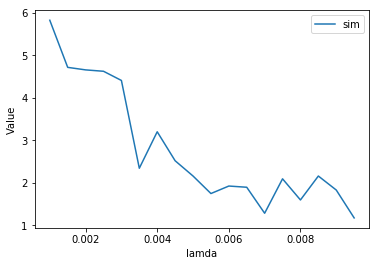

In [3]:
plt.figure()
plt.xlabel("lamda")
plt.ylabel("Value");
plt.plot(lamda_array, sim_array, label="sim")
plt.legend()
plt.savefig('sim_avg.jpg', dpi=350)

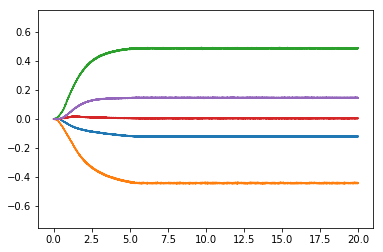

In [7]:
plt.figure()
plt.plot(sim.trange(), sim.data[ik.q_t_probe])
plt.ylim(-0.75, 0.75)
plt.savefig('ik_loihi_images_2/q_t_1_sim.jpg', dpi=350)

In [4]:
with nengo_loihi.Simulator(model,remove_passthrough=False, target='loihi', hardware_options={
    "snip_max_spikes_per_step": 300
}) as sim_loihi:
#    eval_points, activities = tuning_curves(ik.q_t, sim)
    sim_loihi.run(2)
#    sim_loihi.run(10)

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:37169
INFO:DRV:      Host server up..............Done 0.24s
INFO:DRV:      Compiling Embedded snips....Done 0.47s
INFO:DRV:      Compiling Host snips........Done 1.09s
INFO:DRV:      Encoding axons/synapses.....Done 1.24s
INFO:HST:  Args chip=0 cpu=0 /homes/nbel/python3_venv_nxsdk9/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1604255142.975305/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.55s
INFO:DRV:      Encoding probes.............Done 1.02ms
INFO:DRV:      Configuring registers.......Done 0.23s
INFO:DRV:      Transferring spikes.........Done 0.89ms
INFO:DRV:      Transferring probes.........Done 4.03ms
INFO:HST:  [Host] Listening for client
INFO:HST:  [Host] Connected to client
INFO:HST:  chip=0 cpu=0 time 100
INFO:HST:  chip=0 cpu=0 time 200
INFO:HST:  chip=0 cpu=0 time 300
INFO:HST:  chip=0 cp

In [5]:
m = nengo_loihi.builder.Model(dt=0.001)
m.pes_error_scale = 50.
with nengo_loihi.Simulator(model2, model=m, remove_passthrough=False, target='loihi', hardware_options={
    "snip_max_spikes_per_step": 300
}) as sim_loihi2:
#    eval_points, activities = tuning_curves(ik.q_t, sim)
    sim_loihi2.run(2)
#    sim_loihi.run(10)


INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:42407
INFO:DRV:      Host server up..............Done 0.21s
INFO:DRV:      Compiling Host snips........Done 1.13s
INFO:DRV:      Encoding axons/synapses.....Done 1.27s
INFO:DRV:      Compiling Embedded snips....Done 0.50s
INFO:DRV:      Encoding probes.............Done 1.36ms
INFO:HST:  Args chip=0 cpu=0 /homes/nbel/python3_venv_nxsdk9/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1604255191.5444918/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.55s
INFO:DRV:      Transferring probes.........Done 3.20ms
INFO:DRV:      Transferring spikes.........Done 1.00ms
INFO:DRV:      Configuring registers.......Done 0.24s
INFO:HST:  [Host] Listening for client
INFO:HST:  [Host] Connected to client
INFO:HST:  chip=0 cpu=0 time 100
INFO:HST:  chip=0 cpu=0 time 200
INFO:HST:  chip=0 cpu=0 time 300
INFO:HST:  chip=0 c

In [6]:
m = nengo_loihi.builder.Model(dt=0.001)
m.pes_error_scale = 50.
with nengo_loihi.Simulator(model3, model=m, remove_passthrough=False, target='loihi', hardware_options={
    "snip_max_spikes_per_step": 300
}) as sim_loihi3:
#    eval_points, activities = tuning_curves(ik.q_t, sim)
    sim_loihi3.run(2)
#    sim_loihi.run(10)


INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:40055
INFO:DRV:      Host server up..............Done 0.22s
INFO:DRV:      Compiling Host snips........Done 1.14s
INFO:DRV:      Encoding axons/synapses.....Done 1.30s
INFO:DRV:      Compiling Embedded snips....Done 0.49s
INFO:HST:  Args chip=0 cpu=0 /homes/nbel/python3_venv_nxsdk9/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1604255242.854004/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.55s
INFO:DRV:      Encoding probes.............Done 0.75ms
INFO:DRV:      Transferring spikes.........Done 0.95ms
INFO:DRV:      Transferring probes.........Done 4.21ms
INFO:DRV:      Configuring registers.......Done 0.23s
INFO:HST:  [Host] Listening for client
INFO:HST:  [Host] Connected to client
INFO:HST:  chip=0 cpu=0 time 100
INFO:HST:  chip=0 cpu=0 time 200
INFO:HST:  chip=0 cpu=0 time 300
INFO:HST:  chip=0 cp

In [7]:
m = nengo_loihi.builder.Model(dt=0.001)
m.pes_error_scale = 50.
with nengo_loihi.Simulator(model4, model=m, remove_passthrough=False, target='loihi', hardware_options={
    "snip_max_spikes_per_step": 300
}) as sim_loihi4:
#    eval_points, activities = tuning_curves(ik.q_t, sim)
    sim_loihi4.run(2)
#    sim_loihi.run(10)


INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:42141
INFO:DRV:      Host server up..............Done 0.21s
INFO:DRV:      Compiling Host snips........Done 1.13s
INFO:DRV:      Encoding axons/synapses.....Done 1.34s
INFO:DRV:      Compiling Embedded snips....Done 0.54s
INFO:HST:  Args chip=0 cpu=0 /homes/nbel/python3_venv_nxsdk9/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1604255285.2865946/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.55s
INFO:DRV:      Encoding probes.............Done 1.85ms
INFO:DRV:      Configuring registers.......Done 0.23s
INFO:DRV:      Transferring probes.........Done 3.53ms
INFO:DRV:      Transferring spikes.........Done 0.99ms
INFO:HST:  [Host] Listening for client
INFO:HST:  [Host] Connected to client
INFO:HST:  chip=0 cpu=0 time 100
INFO:HST:  chip=0 cpu=0 time 200
INFO:HST:  chip=0 cpu=0 time 300
INFO:HST:  chip=0 c

In [8]:
m = nengo_loihi.builder.Model(dt=0.001)
m.pes_error_scale = 50.
with nengo_loihi.Simulator(model5, model=m, remove_passthrough=False, target='loihi', hardware_options={
    "snip_max_spikes_per_step": 300
}) as sim_loihi5:
#    eval_points, activities = tuning_curves(ik.q_t, sim)
    sim_loihi5.run(2)
#    sim_loihi.run(10)


INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:34451
INFO:DRV:      Host server up..............Done 0.25s
INFO:DRV:      Compiling Host snips........Done 1.11s
INFO:DRV:      Encoding axons/synapses.....Done 1.12s
INFO:DRV:      Compiling Embedded snips....Done 0.51s
INFO:DRV:      Encoding probes.............Done 1.07ms
INFO:HST:  Args chip=0 cpu=0 /homes/nbel/python3_venv_nxsdk9/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1604255334.2675169/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.56s
INFO:DRV:      Configuring registers.......Done 0.23s
INFO:DRV:      Transferring probes.........Done 4.11ms
INFO:DRV:      Transferring spikes.........Done 0.67ms
INFO:HST:  [Host] Listening for client
INFO:HST:  [Host] Connected to client
INFO:HST:  chip=0 cpu=0 time 100
INFO:HST:  chip=0 cpu=0 time 200
INFO:HST:  chip=0 cpu=0 time 300
INFO:HST:  chip=0 c

In [9]:
m = nengo_loihi.builder.Model(dt=0.001)
m.pes_error_scale = 50.
with nengo_loihi.Simulator(model6, model=m, remove_passthrough=False, target='loihi', hardware_options={
    "snip_max_spikes_per_step": 300
}) as sim_loihi6:
#    eval_points, activities = tuning_curves(ik.q_t, sim)
    sim_loihi6.run(2)
#    sim_loihi.run(10)


INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:43181
INFO:DRV:      Host server up..............Done 0.20s
INFO:DRV:      Compiling Host snips........Done 1.13s
INFO:DRV:      Compiling Embedded snips....Done 0.59s
INFO:DRV:      Encoding axons/synapses.....Done 1.10s
INFO:HST:  Args chip=0 cpu=0 /homes/nbel/python3_venv_nxsdk9/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1604255379.0817277/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.55s
INFO:DRV:      Encoding probes.............Done 0.97ms
INFO:DRV:      Transferring spikes.........Done 0.96ms
INFO:DRV:      Transferring probes.........Done 4.90ms
INFO:DRV:      Configuring registers.......Done 0.22s
INFO:HST:  [Host] Listening for client
INFO:HST:  [Host] Connected to client
INFO:HST:  chip=0 cpu=0 time 100
INFO:HST:  chip=0 cpu=0 time 200
INFO:HST:  chip=0 cpu=0 time 300
INFO:HST:  chip=0 c

In [10]:
loihi_e_ik = sum(sim_loihi.data[ik.error_out_probe])/avg
loihi_e_ik11 = sum(sim_loihi.data[ik11.error_out_probe])/avg
loihi_e_ik2 = sum(sim_loihi.data[ik2.error_out_probe])/avg
loihi_e_ik22 = sum(sim_loihi2.data[ik22.error_out_probe])/avg
loihi_e_ik3 = sum(sim_loihi2.data[ik3.error_out_probe])/avg
loihi_e_ik33 = sum(sim_loihi2.data[ik33.error_out_probe])/avg
loihi_e_ik4 = sum(sim_loihi3.data[ik4.error_out_probe])/avg
loihi_e_ik44 = sum(sim_loihi3.data[ik44.error_out_probe])/avg
loihi_e_ik5 = sum(sim_loihi3.data[ik5.error_out_probe])/avg
loihi_e_ik55 = sum(sim_loihi4.data[ik55.error_out_probe])/avg
loihi_e_ik6 = sum(sim_loihi4.data[ik6.error_out_probe])/avg
loihi_e_ik66 = sum(sim_loihi4.data[ik66.error_out_probe])/avg
loihi_e_ik7 = sum(sim_loihi5.data[ik7.error_out_probe])/avg
loihi_e_ik77 = sum(sim_loihi5.data[ik77.error_out_probe])/avg
loihi_e_ik8 = sum(sim_loihi5.data[ik8.error_out_probe])/avg
loihi_e_ik88 = sum(sim_loihi6.data[ik88.error_out_probe])/avg
loihi_e_ik9 = sum(sim_loihi6.data[ik9.error_out_probe])/avg
loihi_e_ik99 = sum(sim_loihi6.data[ik99.error_out_probe])/avg

loihi_sim_array = [loihi_e_ik, loihi_e_ik11, loihi_e_ik2, loihi_e_ik22, loihi_e_ik3, 
             loihi_e_ik33, loihi_e_ik4, loihi_e_ik44, loihi_e_ik5, loihi_e_ik55, 
             loihi_e_ik6, loihi_e_ik66, loihi_e_ik7, loihi_e_ik77, loihi_e_ik8, 
             loihi_e_ik88, loihi_e_ik9, loihi_e_ik99]

In [18]:
data_dict =  {'t': sim.trange(),
              'sim_array':sim_array,
              'lamda_array' : lamda_array,
              'loihi_sim_array' : loihi_sim_array,
              'sim' : sim.data[ik.error_out_probe],
              'sim2' : sim3.data[ik5.error_out_probe],
              'sim3' : sim6.data[ik99.error_out_probe],
              'sim_loihi' : sim_loihi.data[ik.error_out_probe],
              'sim_loihi2' : sim_loihi3.data[ik5.error_out_probe],
              'sim_loihi3' : sim_loihi6.data[ik99.error_out_probe],
}

import pickle
with open('info.pkl','wb') as f:
    pickle.dump(data_dict, f)

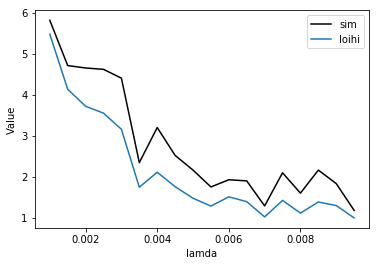

In [22]:
plt.figure()
plt.xlabel("lamda")
plt.ylabel("Value");
plt.plot(lamda_array, sim_array, color="black", label="sim")
plt.plot(lamda_array, loihi_sim_array, label="loihi")
plt.legend()
plt.savefig('loihi_avg.jpg', dpi=350)

In [ ]:
plt.figure()
plt.plot(sim_loihi.trange(), sim_loihi.data[ik.q_t_probe])
plt.ylim(-0.75, 0.75)
plt.savefig('q_t_1_loihi.jpg', dpi=350)

In [ ]:
plt.figure()
plt.xlabel("Time (sec)")
plt.ylabel("lamda 0.001")
plt.plot(sim_loihi.trange(), sim_loihi.data[ik.error_out_probe], label="loihi")
plt.plot(sim.trange(), sim.data[ik.error_out_probe], color="black", label="sim")
plt.ylim(0, 2)
plt.savefig('ik_loihi_images_2/error_out_1.jpg', dpi=350)

In [ ]:
plt.figure()
plt.xlabel("Time (sec)")
plt.ylabel("lamda 0.005")
plt.plot(sim_loihi3.trange(), sim_loihi3.data[ik5.error_out_probe], label="loihi")
plt.plot(sim3.trange(), sim3.data[ik5.error_out_probe],color="black", label="sim")
plt.ylim(0, 2)
plt.savefig('ik_loihi_images_2\error_out_2.jpg', dpi=350)

In [ ]:
plt.figure()
plt.xlabel("Time (sec)")
plt.ylabel("lamda 0.009")
plt.plot(sim_loihi6.trange(), sim_loihi6.data[ik99.error_out_probe], label="loihi")
plt.plot(sim6.trange(), sim6.data[ik99.error_out_probe],color="black", label="sim")
plt.ylim(0, 2)
plt.savefig('ik_loihi_images_2\error_out_3.jpg', dpi=350)

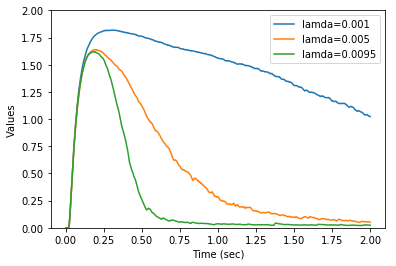

In [19]:
plt.figure()
plt.xlabel("Time (sec)")
plt.ylabel("Values")
plt.plot(sim.trange(), sim.data[ik.error_out_probe], label="lamda=0.001")
plt.plot(sim3.trange(), sim3.data[ik5.error_out_probe], label="lamda=0.005")
plt.plot(sim6.trange(), sim6.data[ik99.error_out_probe], label="lamda=0.0095")
plt.legend()
plt.ylim(0, 2)
plt.savefig('ik_loihi_images_2\error_out_sim.jpg', dpi=350)

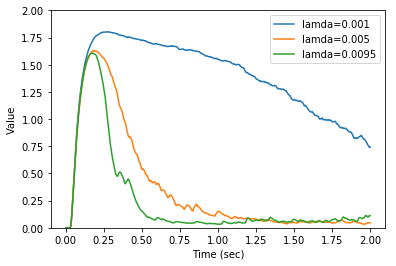

In [20]:
plt.figure()
plt.xlabel("Time (sec)")
plt.ylabel("Value");
plt.plot(sim_loihi.trange(), sim_loihi.data[ik.error_out_probe], label="lamda=0.001")
plt.plot(sim_loihi3.trange(), sim_loihi3.data[ik5.error_out_probe], label="lamda=0.005")
plt.plot(sim_loihi6.trange(), sim_loihi6.data[ik99.error_out_probe], label="lamda=0.0095")
plt.ylim(0, 2)
plt.legend()
plt.savefig('ik_loihi_images_2\error_out_loihi.jpg', dpi=350)


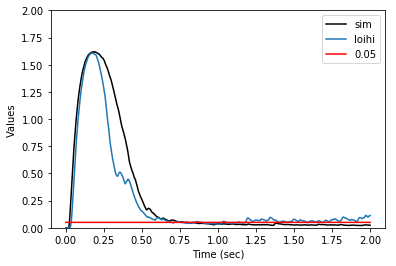

In [21]:
plt.figure()
plt.xlabel("Time (sec)")
plt.ylabel("Values")
plt.plot(sim6.trange(), sim6.data[ik99.error_out_probe], color="black", label="sim")
plt.plot(sim_loihi6.trange(), sim_loihi6.data[ik99.error_out_probe], label="loihi")
plt.plot(sim_loihi6.trange(), np.full([len(sim_loihi6.data[ik99.error_out_probe])], 0.05),color="red", label="0.05")

plt.legend()
plt.ylim(0, 2)
plt.savefig('ik_loihi_images_2\error_out_sim_loihi.jpg', dpi=350)